In [1]:
import sys
# sys.argv.append("-lc=C:/Workspaces/AIC/simod/local_config_files/AIC/Manhattan/vga-manhattan-start_1830-real_speeds.cfg")
sys.argv.append("-lc=C:/Workspaces/AIC/simod-master/local_config_files/AIC/Manhattan/vga-manhattan-start_1830-real_speeds.cfg")
from simod.init import config

INFO:root:Loading config for project RoadmaptoolsConfig (can be overwritten later)
INFO:root:map_dir: FILL YOUR MAP DIR HERE
osm_source_url: https://s3.amazonaws.com/metro-extracts.mapzen.com/valencia_spain.osm.bz2
osm_map_filename: FILL YOUR MAP DIR HEREmap.osm
filtered_osm_filename: FILL YOUR MAP DIR HEREmap-filtered.osm
geojson_file: FILL YOUR MAP DIR HEREmap.geojson
cleaned_geojson_file: FILL YOUR MAP DIR HEREmap-cleaned.geojson
sanitized_geojson_file: FILL YOUR MAP DIR HEREmap-sanitized.geojson
simplified_file: FILL YOUR MAP DIR HEREmap-simplified.geojson
simplified_file_with_speed: FILL YOUR MAP DIR HEREmap-simplified-speed.geojson
simplified_file_with_speed_and_curvature: FILL YOUR MAP DIR HEREmap-simplified-speed-curvature.geojson
ap_nodes_file: FILL YOUR MAP DIR HEREnodes.geojson
ap_edges_file: FILL YOUR MAP DIR HEREedges.geojson
utm_center_lon: 50.0877506
utm_center_lat: 14.4209293
shift_utm_coordinate_origin_to_utm_center: False
shapely_error_tolerance: 0.005
osm_filter_para

In [5]:
from typing import List, Dict
from pandas import DataFrame
import pandas.errors
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


import roadmaptools.inout
from roadmaptools.printer import print_table, print_info
from simod.statistics.traffic_density_histogram import TrafficDensityHistogram
import simod.statistics.model.transit as transit
import simod.statistics.model.traffic_load as traffic_load
import simod.statistics.model.occupancy as occupancy
import simod.statistics.model.ridesharing as ridesharing
import simod.statistics.model.service as service
import simod.statistics.model.edges as edges
import simod.statistics.comparisons.common as common

In [6]:
def compute_stats(experiment_dir: str, histogram: TrafficDensityHistogram, edge_data: DataFrame) -> List:
    result: Dict = roadmaptools.inout.load_json(experiment_dir + config.statistics.result_file_name)

    # km total
    transit_data = transit.load(experiment_dir)

    # km_total = int(round(avg_km_total * result["numberOfVehicles"]))
    km_total = transit.get_total_distance(transit_data, edge_data) / 1000 / 100
    km_total_window = int(round(transit.get_total_distance(transit_data, edge_data, True) / 1000 / 100))

    # average density
    load = traffic_load.load_all_edges_load_history(experiment_dir + config.statistics.all_edges_load_history_file_name)["ALL"]
    average_density_list_total_future = histogram.get_average_density_list(load)
    average_density_in_time_window_non_empty_edges = np.average(average_density_list_total_future)

    # congested count
    congested_count_in_time_window = np.where(average_density_list_total_future > config.critical_density)[0].size

    dropped_demand_count = result["numberOfDemandsDropped"]

    # half congested edges
    half_congested_count_in_time_window \
        = np.where(average_density_list_total_future > (config.critical_density / 2))[0].size

    occuopancies = occupancy.load(experiment_dir)
    occupancies_in_window = occupancy.filter_window(occuopancies)
    used_cars_count = len(occupancies_in_window.vehicle_id.unique())

    # performance
    try:
        performance_data = ridesharing.load(experiment_dir)
        if 'Insertion Heuristic Time' in performance_data:
            avg_time = performance_data['Insertion Heuristic Time'].mean()
        else:
            avg_time = performance_data['Group Generation Time'].mean() + performance_data['Solver Time'].mean()
        avg_time = int(round(avg_time))
    except pandas.errors.EmptyDataError:
        print_info("Empty ridesharing statistic")
        avg_time = "-1"

    # delay
    service_stat = service.load_dataframe(experiment_dir)
    delays_window = service.get_delays(service_stat, True, False)
    mean_delay = int(round(delays_window.mean() / 1000))

    return [
        km_total_window, 
        average_density_in_time_window_non_empty_edges, 
        congested_count_in_time_window,
        dropped_demand_count, 
        half_congested_count_in_time_window, 
        used_cars_count, 
        avg_time, 
        mean_delay,
        occupancies_in_window
    ]

In [7]:
# edges
loaded_edges = roadmaptools.inout.load_geojson(config.agentpolis.map_edges_filepath)
edge_data = edges.make_data_frame(loaded_edges)
edge_object_data = edges.load_edges_mapped_by_id(loaded_edges)

[22:37:45]: Loading geojson file from: C:\AIC Experiment Data\VGA Manhattan\maps\edges_with_measured_speed.geojson


In [9]:
experiment_dirs = [
    config.comparison.experiment_1_dir,
    config.comparison.experiment_2_dir,
    config.comparison.experiment_3_dir,
    config.comparison.experiment_4_dir,
    config.comparison.experiment_9_dir
]

In [10]:
# Manhattan temp fix
experiment_dirs = [exd[:-1] + "-start_1830-real_speeds/" for exd in experiment_dirs]

In [11]:
experiment_dirs

['C:/AIC Experiment Data/VGA Manhattan/experiments/ih-nr-start_1830-real_speeds/',
 'C:/AIC Experiment Data/VGA Manhattan/experiments/ih-start_1830-real_speeds/',
 'C:/AIC Experiment Data/VGA Manhattan/experiments/vga_gap_0002-start_1830-real_speeds/',
 'C:/AIC Experiment Data/VGA Manhattan/experiments/vga-lim_gap_005_gg_60ms-start_1830-real_speeds/',
 'C:/AIC Experiment Data/VGA Manhattan/experiments/vga-pnas-start_1830-real_speeds/']

In [10]:
histogram = TrafficDensityHistogram(edge_object_data)

In [14]:
no_ridesharing_data = compute_stats(experiment_dirs[0], histogram, edge_data)
insertion_heuristic_data = compute_stats(experiment_dirs[1], histogram, edge_data)
vga_data = compute_stats(experiment_dirs[2], histogram, edge_data)
vga_limited_data = compute_stats(experiment_dirs[3], histogram, edge_data)
vga_pnas_data = compute_stats(experiment_dirs[4], histogram, edge_data)

[10:10:38]: Loading json file from: C:\AIC Experiment Data\VGA Manhattan\experiments\ih-nr-start_1830-real_speeds\result.json
[10:10:45]: Loading edge load history from: C:/AIC Experiment Data/VGA Manhattan/experiments/ih-nr-start_1830-real_speeds/allEdgesLoadHistory.json
[10:10:45]: counting average load
[10:10:46]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\ih-nr-start_1830-real_speeds\ridesharing.csv to dataframe
[10:10:46]: Loading json file from: C:\AIC Experiment Data\VGA Manhattan\experiments\ih-start_1830-real_speeds\result.json
[10:10:48]: Loading edge load history from: C:/AIC Experiment Data/VGA Manhattan/experiments/ih-start_1830-real_speeds/allEdgesLoadHistory.json
[10:10:48]: counting average load
[10:10:49]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\ih-start_1830-real_speeds\ridesharing.csv to dataframe
[10:10:49]: Loading json file from: C:\AIC Experiment Data\VGA Manhattan\experiments\vga_gap_0002-start_1830-re

In [15]:
# vga_pnas_data = compute_stats(experiment_dirs[4], histogram, edge_data)
vga_pnas_unlimited_vehicles_data = compute_stats(r"C:\AIC Experiment Data\VGA Manhattan\experiments/vga-pnas_unlimeted_vehicles-start_1830-real_speeds/", histogram, edge_data)

[10:11:37]: Loading json file from: C:\AIC Experiment Data\VGA Manhattan\experiments\vga-pnas_unlimeted_vehicles-start_1830-real_speeds\result.json
[10:11:40]: Loading edge load history from: C:\AIC Experiment Data\VGA Manhattan\experiments/vga-pnas_unlimeted_vehicles-start_1830-real_speeds/allEdgesLoadHistory.json
[10:11:40]: counting average load
[10:11:40]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\vga-pnas_unlimeted_vehicles-start_1830-real_speeds\ridesharing.csv to dataframe


In [16]:
output_table = np.array([["X", "NO RIDESHARING", "INSERTION HEURISTIC", "VGA", "VGA limited", "VGA PNAS", "VGA PNAS (unlimited vehicles)"],
						 ["Total veh. dist. traveled (km)", no_ridesharing_data[0], insertion_heuristic_data[0], vga_data[0], vga_limited_data[0], vga_pnas_data[0], vga_pnas_unlimited_vehicles_data[0]],
						 ["avg. density", no_ridesharing_data[1], insertion_heuristic_data[1], vga_data[1], vga_limited_data[1], vga_pnas_data[1], vga_pnas_unlimited_vehicles_data[1]],
						 ["cong. segments count", no_ridesharing_data[2], insertion_heuristic_data[2], vga_data[2], vga_limited_data[2], vga_pnas_data[2], vga_pnas_unlimited_vehicles_data[2]],
						 ["dropped demand count", no_ridesharing_data[3], insertion_heuristic_data[3], vga_data[3], vga_limited_data[3], vga_pnas_data[3], vga_pnas_unlimited_vehicles_data[3]],
						 ["half congested edges", no_ridesharing_data[4], insertion_heuristic_data[4], vga_data[4], vga_limited_data[4], vga_pnas_data[4], vga_pnas_unlimited_vehicles_data[4]],
						 ["used car count", no_ridesharing_data[5], insertion_heuristic_data[5], vga_data[5], vga_limited_data[5], vga_pnas_data[5], vga_pnas_unlimited_vehicles_data[5]],
						 ["avg. delay", no_ridesharing_data[7], insertion_heuristic_data[7], vga_data[7], vga_limited_data[7], vga_pnas_data[7], vga_pnas_unlimited_vehicles_data[7]],
						 ["avg. comp. time", no_ridesharing_data[6], insertion_heuristic_data[6], vga_data[6], vga_limited_data[6], vga_pnas_data[6], vga_pnas_unlimited_vehicles_data[6]]])

In [17]:
# console results
print("COMPARISON:")
print()
print_table(output_table)

COMPARISON:


X                               NO RIDESHARING                  INSERTION HEURISTIC             VGA                             VGA limited                     VGA PNAS                        VGA PNAS (unlimited vehicles)   
Total veh. dist. traveled (km)  868899                          362387                          334195                          334737                          377563                          344057                          
avg. density                    0.018292019530753472            0.008506879323291196            0.008040484528698252            0.008024886924264478            0.008855023921188943            0.008219664412244306            
cong. segments count            220                             9                               9                               8                               14                              10                              
dropped demand count            0                               27                    

In [18]:
# latex table
print("Latex code:")
print(r"{\renewcommand{\arraystretch}{1.2}%")
print(r"\begin{tabular}{|+l|-r|-r|-r|-r|-r|}")
print(r"\hline")
print(r" & \thead{No Ridesh.} & \thead{IH} & \thead{VGA} & \thead{VGA lim} & \thead{VGA PNAS*}")
print(r"\tabularnewline")
print(r"\hline")
print(r"\hline")
print("Optimal & no & no & yes & no & no")
print(r"\tabularnewline")
print(r"\hline")
print(r"\rowstyle{\bfseries}")
print("Total veh. dist. (km) & \\num{{{}}} & \\num{{{}}} & \\num{{{}}} & \\num{{{}}}& \\num{{{}}} (\\num{{{}}})".format(no_ridesharing_data[0],
	insertion_heuristic_data[0], vga_data[0], vga_limited_data[0], vga_pnas_data[0], vga_pnas_unlimited_vehicles_data[0]))
print(r"\tabularnewline")
print(r"\hline")
print("Avg. delay (s) & \\num{{{}}} & \\num{{{}}} & \\num{{{}}} & \\num{{{}}} & \\num{{{}}} (\\num{{{}}})".format(no_ridesharing_data[7], insertion_heuristic_data[7], vga_data[7],
	vga_limited_data[7], vga_pnas_data[7], vga_pnas_unlimited_vehicles_data[7]))
print(r"\tabularnewline")
print(r"\hline")
print("Avg. density (veh/km) & \\num{{{}}} & \\num{{{}}} & \\num{{{}}} & \\num{{{}}} & \\num{{{}}} (\\num{{{}}})".format(round(no_ridesharing_data[1], 4),
	 round(insertion_heuristic_data[1], 4), round(vga_data[1], 4), round(vga_limited_data[1], 4), round(vga_pnas_data[1], 4),
    round(vga_pnas_unlimited_vehicles_data[1], 4)))
print(r"\tabularnewline")
print(r"\hline")
print("Congested seg. & \\num{{{}}} & \\num{{{}}} & \\num{{{}}} & \\num{{{}}} & \\num{{{}}} (\\num{{{}}})".format(no_ridesharing_data[2], insertion_heuristic_data[2], vga_data[2],
	vga_limited_data[2], vga_pnas_data[2], vga_pnas_unlimited_vehicles_data[2] ))
print(r"\tabularnewline")
print(r"\hline")
print("Heavily loaded seg.  & \\num{{{}}} & \\num{{{}}} & \\num{{{}}} & \\num{{{}}} & \\num{{{}}} (\\num{{{}}})".format(round(no_ridesharing_data[4], 1),
	round(insertion_heuristic_data[4], 1), round(vga_data[4], 1), round(vga_limited_data[4], 1), round(vga_pnas_data[4], 1),
     round(vga_pnas_unlimited_vehicles_data[4], 1)))
print(r"\tabularnewline")
print(r"\hline")
print("Used Vehicles  & \\num{{{}}} & \\num{{{}}} & \\num{{{}}} & \\num{{{}}} & \\num{{{}}} (\\num{{{}}})".format(no_ridesharing_data[5], insertion_heuristic_data[5], vga_data[5],
	vga_limited_data[5], vga_pnas_data[5], vga_pnas_unlimited_vehicles_data[5]))
print(r"\tabularnewline")
print(r"\hline")
print("Avg. comp. time (ms)  & \\num{{{}}} & \\num{{{}}} & \\num{{{}}} & \\num{{{}}} & \\num{{{}}} (\\num{{{}}})".format(no_ridesharing_data[6], insertion_heuristic_data[6], vga_data[6],
	vga_limited_data[6], vga_pnas_data[6], vga_pnas_unlimited_vehicles_data[6]))
print(r"\tabularnewline")
print(r"\hline")
print(r"\end{tabular}}")

Latex code:
{\renewcommand{\arraystretch}{1.2}%
\begin{tabular}{|+l|-r|-r|-r|-r|-r|}
\hline
 & \thead{No Ridesh.} & \thead{IH} & \thead{VGA} & \thead{VGA lim} & \thead{VGA PNAS*}
\tabularnewline
\hline
\hline
Optimal & no & no & yes & no & no
\tabularnewline
\hline
\rowstyle{\bfseries}
Total veh. dist. (km) & \num{868899} & \num{362387} & \num{334195} & \num{334737}& \num{377563} (\num{344057})
\tabularnewline
\hline
Avg. delay (s) & \num{109} & \num{117} & \num{109} & \num{109} & \num{83} (\num{110})
\tabularnewline
\hline
Avg. density (veh/km) & \num{0.0183} & \num{0.0085} & \num{0.008} & \num{0.008} & \num{0.0089} (\num{0.0082})
\tabularnewline
\hline
Congested seg. & \num{220} & \num{9} & \num{9} & \num{8} & \num{14} (\num{10})
\tabularnewline
\hline
Heavily loaded seg.  & \num{692} & \num{129} & \num{117} & \num{112} & \num{152} (\num{115})
\tabularnewline
\hline
Used Vehicles  & \num{46186} & \num{20272} & \num{19714} & \num{19712} & \num{22545} (\num{20293})
\tabularnewline
\hli

# Occupancy Histogram Comparison

In [104]:
def configure_subplot(axis):
	axis.yaxis.set_ticks(np.arange(0, 2040002, 240000))
	axis.yaxis.set_major_formatter(FuncFormatter(format_time))
	axis.xaxis.set_ticks(np.arange(0, 6, 1))
    
def format_time(minutes: int, position) -> str:
	# return str(datetime.timedelta(minutes=minutes))
	return str(int(round(minutes / 60)))

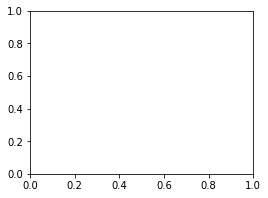

In [89]:
fig, axis = plt.subplots(1, 1, figsize=(4, 3))

# decrease space between subplots
fig.subplots_adjust(wspace=0.05)

In [105]:
axis.set_xlabel("persons per vehicle")
axis.set_ylabel("vehicle hours")
configure_subplot(axis)

In [91]:
occupancy_data = [
    no_ridesharing_data[8]['occupancy'], 
    insertion_heuristic_data[8]['occupancy'], 
    vga_data[8]['occupancy'], 
    vga_limited_data[8]['occupancy'], 
    vga_pnas_data[8]['occupancy']
]
bins = np.arange(-0.5, 6.5, 1)
_n, _bins, patches = axis.hist(occupancy_data, bins, label=common.labels[1:], color=common.colors[1:])

In [94]:
for patch_set, hatch in zip(patches, common.hatches):
    plt.setp(patch_set, hatch=hatch)

In [96]:
axis.legend(loc='upper right')

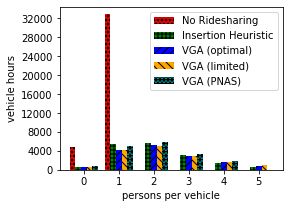

In [106]:
fig

In [107]:
fig.savefig(
    config.images.occupancy_histogram_comparison_combined, 
    bbox_inches='tight', 
    transparent=True, 
    pad_inches=0.02, 
    dpi=fig.dpi
)

# Comparison table - delay 7  min capacity 10


In [13]:
experiment_dirs = [
    r"C:\AIC Experiment Data\VGA Manhattan\experiments\max_delay_7_min_capacity_10\ih/",
    r"C:\AIC Experiment Data\VGA Manhattan\experiments\max_delay_7_min_capacity_10\vga-lim/",
    r"C:\AIC Experiment Data\VGA Manhattan\experiments\max_delay_7_min_capacity_10\vga-pnas/"
]

In [14]:
insertion_heuristic_data_hard_exp = compute_stats(experiment_dirs[0], histogram, edge_data)
vga_limited_data_hard_exp = compute_stats(experiment_dirs[1], histogram, edge_data)
vga_pnas_data_hard_exp = compute_stats(experiment_dirs[2], histogram, edge_data)

[22:53:54]: Loading json file from: C:\AIC Experiment Data\VGA Manhattan\experiments\max_delay_7_min_capacity_10\ih\result.json
[22:53:57]: Loading edge load history from: C:\AIC Experiment Data\VGA Manhattan\experiments\max_delay_7_min_capacity_10\ih/allEdgesLoadHistory.json
[22:53:57]: counting average load
[22:53:57]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\max_delay_7_min_capacity_10\ih\ridesharing.csv to dataframe
[22:53:57]: Loading json file from: C:\AIC Experiment Data\VGA Manhattan\experiments\max_delay_7_min_capacity_10\vga-lim\result.json
[22:53:59]: Loading edge load history from: C:\AIC Experiment Data\VGA Manhattan\experiments\max_delay_7_min_capacity_10\vga-lim/allEdgesLoadHistory.json
[22:53:59]: counting average load
[22:54:00]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\max_delay_7_min_capacity_10\vga-lim\ridesharing.csv to dataframe
[22:54:00]: Loading json file from: C:\AIC Experiment Data\VGA Manhattan\ex

In [15]:
output_table = np.array([["X", "INSERTION HEURISTIC", "VGA limited", "VGA PNAS (unlimited vehicles)"],
						 ["Total veh. dist. traveled (km)", insertion_heuristic_data_hard_exp[0], vga_limited_data_hard_exp[0], vga_pnas_data_hard_exp[0]],
						 ["avg. density", insertion_heuristic_data_hard_exp[1], vga_limited_data_hard_exp[1], vga_pnas_data_hard_exp[1]],
						 ["cong. segments count", insertion_heuristic_data_hard_exp[2], vga_limited_data_hard_exp[2], vga_pnas_data_hard_exp[2]],
						 ["dropped demand count", insertion_heuristic_data_hard_exp[3], vga_limited_data_hard_exp[3], vga_pnas_data_hard_exp[3]],
						 ["half congested edges", insertion_heuristic_data_hard_exp[4], vga_limited_data_hard_exp[4], vga_pnas_data_hard_exp[4]],
						 ["used car count", insertion_heuristic_data_hard_exp[5], vga_limited_data_hard_exp[5], vga_pnas_data_hard_exp[5]],
						 ["avg. delay", insertion_heuristic_data_hard_exp[7], vga_limited_data_hard_exp[7], vga_pnas_data_hard_exp[7]],
						 ["avg. comp. time", insertion_heuristic_data_hard_exp[6], vga_limited_data_hard_exp[6], vga_pnas_data_hard_exp[6]]])

In [16]:
# console results
print("COMPARISON - delay 7 minute, vehicle capacity 10:")
print()
print_table(output_table)

COMPARISON - delay 7 minute, vehicle capacity 10:


X                               INSERTION HEURISTIC             VGA limited                     VGA PNAS (unlimited vehicles)   
Total veh. dist. traveled (km)  233859                          275028                          267471                          
avg. density                    0.005962926163576181            0.006707806609071858            0.006615194417454474            
cong. segments count            0                               1                               0                               
dropped demand count            0                               0                               0                               
half congested edges            24                              53                              48                              
used car count                  13319                           16517                           16025                           
avg. delay                      227          

In [18]:
# latex table
print("Latex code:")
print(r"{\renewcommand{\arraystretch}{1.2}%")
print(r"\begin{tabular}{|+l|-r|-r|-r|-r|-r|}")
print(r"\hline")
print(r" & \thead{IH} & \thead{VGA lim} & \thead{VGA PNAS*}")
print(r"\tabularnewline")
print(r"\hline")
print(r"\hline")
print("Optimal & no & no & yes & no & no")
print(r"\tabularnewline")
print(r"\hline")
print(r"\rowstyle{\bfseries}")
print("Total veh. dist. (km) & \\num{{{}}} & \\num{{{}}} & \\num{{{}}}".format(
    insertion_heuristic_data_hard_exp[0], vga_limited_data_hard_exp[0], vga_pnas_data_hard_exp[0]))
print(r"\tabularnewline")
print(r"\hline")
print("Avg. delay (s) & \\num{{{}}} & \\num{{{}}} & \\num{{{}}}".format(
    insertion_heuristic_data_hard_exp[7], vga_limited_data_hard_exp[7], vga_pnas_data_hard_exp[7]))
print(r"\tabularnewline")
print(r"\hline")
print("Avg. density (veh/km) & \\num{{{}}} & \\num{{{}}} & \\num{{{}}}".format(
    round(insertion_heuristic_data_hard_exp[1], 4), round(vga_limited_data_hard_exp[1], 4), round(vga_pnas_data_hard_exp[1], 4)))
print(r"\tabularnewline")
print(r"\hline")
print("Congested seg. & \\num{{{}}} & \\num{{{}}} & \\num{{{}}}".format(
    insertion_heuristic_data_hard_exp[2], vga_limited_data_hard_exp[2], vga_pnas_data_hard_exp[2]))
print(r"\tabularnewline")
print(r"\hline")
print("Heavily loaded seg.  & \\num{{{}}} & \\num{{{}}} & \\num{{{}}}".format(
    round(insertion_heuristic_data_hard_exp[4], 1), round(vga_limited_data_hard_exp[4], 1), round(vga_pnas_data_hard_exp[4], 1)))
print(r"\tabularnewline")
print(r"\hline")
print("Used Vehicles  & \\num{{{}}} & \\num{{{}}} & \\num{{{}}}".format(
    insertion_heuristic_data_hard_exp[5], vga_limited_data_hard_exp[5], vga_pnas_data_hard_exp[5]))
print(r"\tabularnewline")
print(r"\hline")
print("Avg. comp. time (ms)  & \\num{{{}}} & \\num{{{}}} & \\num{{{}}}".format(
    insertion_heuristic_data_hard_exp[6], vga_limited_data_hard_exp[6], vga_pnas_data_hard_exp[6]))
print(r"\tabularnewline")
print(r"\hline")
print(r"\end{tabular}}")

Latex code:
{\renewcommand{\arraystretch}{1.2}%
\begin{tabular}{|+l|-r|-r|-r|-r|-r|}
\hline
 & \thead{IH} & \thead{VGA lim} & \thead{VGA PNAS*}
\tabularnewline
\hline
\hline
Optimal & no & no & yes & no & no
\tabularnewline
\hline
\rowstyle{\bfseries}
Total veh. dist. (km) & \num{233859} & \num{275028} & \num{267471}
\tabularnewline
\hline
Avg. delay (s) & \num{227} & \num{224} & \num{217}
\tabularnewline
\hline
Avg. density (veh/km) & \num{0.006} & \num{0.0067} & \num{0.0066}
\tabularnewline
\hline
Congested seg. & \num{0} & \num{1} & \num{0}
\tabularnewline
\hline
Heavily loaded seg.  & \num{24} & \num{53} & \num{48}
\tabularnewline
\hline
Used Vehicles  & \num{13319} & \num{16517} & \num{16025}
\tabularnewline
\hline
Avg. comp. time (ms)  & \num{25} & \num{57554} & \num{139811}
\tabularnewline
\hline
\end{tabular}}


In [101]:
no_ridesharing_data[8]['occupancy'].count()

2254122

In [102]:
insertion_heuristic_data[8]['occupancy'].count()

995790